## Localization Task

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers as tfkl, models as tfkm
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications.resnet import preprocess_input
#from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
from matplotlib import pyplot as plt
import numpy as np
import argparse
import imutils
import time
import cv2
import os
import numpy as np
import random
from sklearn.utils import class_weight
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle


In [4]:
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Same setting as before

In [5]:
clues_df = pd.read_csv('clues.csv', index_col=0)
clues_df.head()

,Gate,Ball,Referee
img_id,,,
1,0,0,0
2,0,0,1
94,0,1,1
95,0,1,1
96,0,1,1


## Weakly Supervised Object Localization (WSOL)

## Step 1. GAP + FC + CAM

In [6]:
image_ids = clues_df.index.astype(str).to_numpy()
gate_label = clues_df['Gate'].values

In [7]:
print(f"Nr images: {len(image_ids)}")
print(f"Label Gate Distribution:\n 0\t\t1")
print("----------------------")
print(f"{sum(gate_label.tolist()) / len(image_ids)}\t\t{1- (sum(gate_label.tolist()) / len(image_ids))}")

Nr images: 10000
Label Gate Distribution:
 0		1
----------------------
0.415		0.585


### MobileNetV2

In [8]:
# train-test split
train_ids, val_ids, y_train, y_val = train_test_split(
    image_ids, gate_label,
    test_size=0.2,
    stratify=gate_label,
    random_state=SEED
)

#### Loading and Preprocessing

We defining the image loader: (256x256) as accepted input size for the model (must be squared).

In [9]:
target_dim = (256, 256)

def load_images_from_path(image_ids, path="Filtered_Dataset", img_dim=(224, 224)):
    images = []
    for img_id in image_ids:
        img_path = os.path.join(path, f"{img_id}.jpg")
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_dim)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    return np.array(images, dtype='float32')



def load_images_original(image_ids, path="Filtered_Dataset"):
    images=[]
    for img_id in image_ids:
        img_path = os.path.join(path, f"{img_id}.jpg")
        img_bgr = cv2.imread(img_path)  # BGR, original size
        if img_bgr is not None:
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # To RGB, still original
            images.append(img_rgb)
    
    original_shape = img_rgb.shape[:2]  # (H, W) (enough one img)
    return np.array(images, dtype='float32'), original_shape

In [10]:
# load raw:
X_train = load_images_from_path(train_ids, img_dim=target_dim)
X_val  = load_images_from_path(val_ids, img_dim=target_dim)

In [11]:
# preprocessing for MobileNetV2
# Rescales input from [-1, 1]
X_train_pre = preprocess_input(X_train)
X_val_pre = preprocess_input(X_val)

Rebalancing classes:

In [12]:
from sklearn.utils import class_weight

weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {0: weights_array[0], 1: weights_array[1]}

In [13]:
input_shape = (target_dim[0], target_dim[1], 3)


def mobnetv2_gate(input_shape=input_shape):
    base = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base.trainable = False

    inputs = tfkl.Input(shape=input_shape)
    x = base(inputs)

    # apply GAP --> reduces feature map from (7,7,1280) to (1280,)
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    # FC dense layer, single output unit
    # binary classification --> pr(referee in the image)
    output = tfkl.Dense(1, activation='sigmoid', name='MobileNetV2_Ref')(x)

    model = tfkm.Model(inputs=inputs, outputs=output)
    return model

In [14]:
gate_model1 = mobnetv2_gate()

gate_model1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision')]
)

history = gate_model1.fit(
                    X_train_pre, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val_pre, y_val),
                    class_weight=class_weights,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
                    ],
                    verbose=1
                )


C:\Users\Utente\AppData\Local\Temp\ipykernel_41272\4129318421.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 0.7694 - loss: 0.4668 - precision: 0.6986 - val_accuracy: 0.8580 - val_loss: 0.3233 - val_precision: 0.8027
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 182s 718ms/step - accuracy: 0.8653 - loss: 0.3047 - precision: 0.8150 - val_accuracy: 0.8730 - val_loss: 0.2906 - val_precision: 0.8310
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 170s 679ms/step - accuracy: 0.8822 - loss: 0.2761 - precision: 0.8420 - val_accuracy: 0.8825 - val_loss: 0.2761 - val_precision: 0.8521
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 171s 684ms/step - accuracy: 0.8897 - loss: 0.2592 - precision: 0.8494 - val_accuracy: 0.8885 - val_loss: 0.2674 - val_precision: 0.8670
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 162s 647ms/step - accuracy: 0.8946 - loss: 0.2469 - precision: 0.8579 - val_accuracy: 0.8930 - val_loss: 0.2615 - val_precision: 0.8756
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 171s 686ms/step - accuracy: 0.9000 - loss: 0.2371 - precision: 0.8641 - val_accurac

In [15]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['precision'], label='train_precision')
    plt.plot(history.history['val_precision'], label='val_precision')
    plt.title('Accuracy and Precision over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


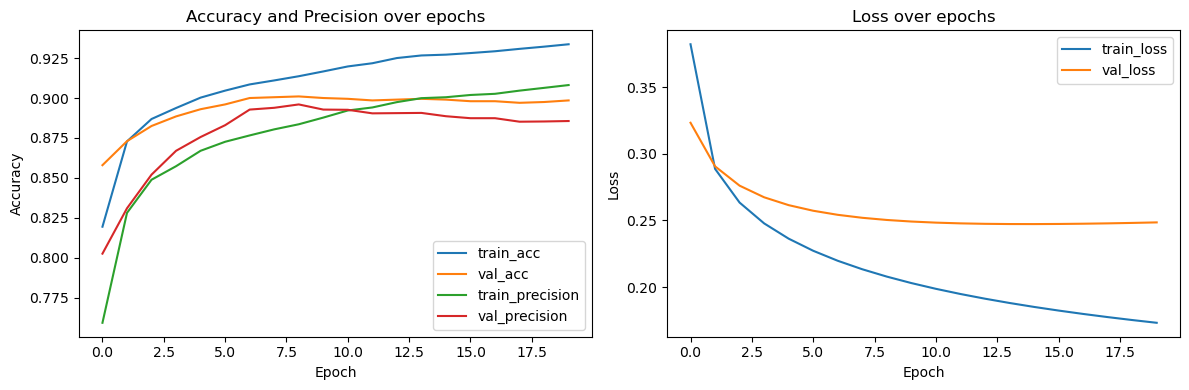

In [16]:
plot_training_history(history)

tune sensitivity: can apply a decision threshold to reduce false positives

In [17]:
y_probs = gate_model1.predict(X_val_pre, batch_size=32)

63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 532ms/step


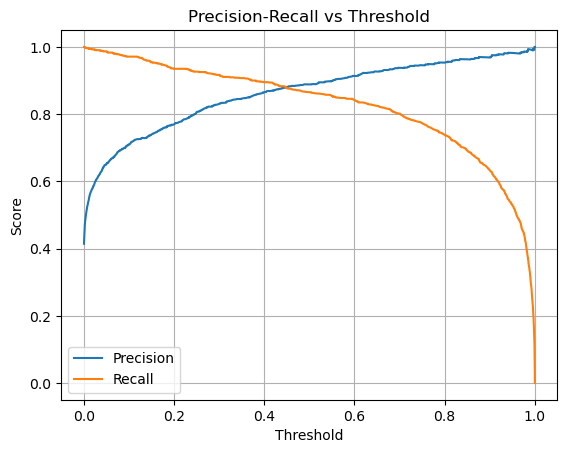

In [18]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)

plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

Save model

In [20]:
gate_model1.save("Gate_CAM_Model.h5")

In [21]:
gate_model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV2_Ref (Dense)         │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,829 (8.63 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2,564 (10.02 KB)

## Generate Cam

In [17]:
from PIL import Image

CAM = $\sum_k w_k f_k(x)$,
- $w_k$: weights from dense layer
- $f_k(x)$: activation maps from final conv layer

CAMs represent the areas of maximum 'attention' in the image. Therefore, as the model is trained on a binary classification task, I expect (hope) the focus to be high near the area where the object is located.

Cams will be used as a proxy to extract the bounding boxes needed for the analysis.

In [22]:
def generate_cam(model, img_id, req_dim=target_dim, class_index=0, return_original=False):

    """
    Generates a CAM for a given image ID.
    Returns the resized CAM (to match resized image),
    and optionally the original image and shape.

    Input: model, img_id:int, return_original (defaults to False)
    Output: return_original=False --> cam resized to (256, 256), img_pre (np.array)
            return_original=True --> cam x target, img_pre, cam x original, img_orig
    """

    # Load and preprocess resized image (for model input)
    img_raw = load_images_from_path([img_id], img_dim=req_dim)[0]
    img_pre = preprocess_input(img_raw.astype(np.float32))  # shape: (256, 256, [-1,1]^3)

    # Load original image (if required)
    if return_original:
        img_orig, orig_shape = load_images_original([img_id])
        img_orig = img_orig[0]  # unwrap batch
        h_orig, w_orig = orig_shape

    # Get conv features from model
    base_model = model.get_layer("mobilenetv2_1.00_224")
    conv_layer = base_model.get_layer("Conv_1")
    conv_model = tf.keras.Model(inputs=base_model.input, outputs=conv_layer.output)

    image_batch = np.expand_dims(img_pre, axis=0)
    conv_output = conv_model(image_batch)[0].numpy()  

    # weighted sum----> warning: same name as referee model (forgot to change name but just layer name, fine)
    weights = model.get_layer("MobileNetV2_Ref").get_weights()[0][:, class_index]
    cam = np.dot(conv_output, weights)
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    cam_resized = cv2.resize(cam, req_dim)

    if return_original:
        # Resize to original img dim
        cam_resized_original = cv2.resize(cam, (w_orig, h_orig))
        return cam_resized, img_pre, cam_resized_original, img_orig
    else:
        return cam_resized, img_pre

In [23]:
def overlay_cam_on_image(image_array, cam, alpha=0.5, cmap='jet', title="CAM Overlay"):
    """
    Overlays a CAM heatmap on the given RGB image.

    Args:
        image: np.ndarray, RGB image of shape (H, W, 3), original or resized
        cam: np.ndarray, heatmap of shape (H, W), same as image
        alpha: blending factor
        cmap: color map (currently unused since we use cv2 COLORMAP_JET)
        title: plot title
    """
    assert image_array.shape[:2] == cam.shape, f"CAM shape {cam.shape} and image shape {image_array.shape[:2]} must match."

    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # BGR
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # to RGB

    # Blend heatmap and image
    overlay = cv2.addWeighted(image_array.astype(np.uint8), 1 - alpha, heatmap, alpha, 0)

    # Show
    plt.imshow(overlay)
    plt.axis("off")
    plt.title(title)
    plt.show()

#### 1. Compare CAMs for Label=1 and Label=0 Images:
- is it worth taking the bounding box of *all* images?
- all the ones with label=1?
- the ones that satisfy some threshold? 

##### 1.a Label=1

In [74]:
folder = "Filtered_Dataset/"
clues_df[clues_df['Gate'] == 1].sample(10).index

Index([24112, 94494, 7599, 17200, 90934, 40592, 84154, 55998, 88562, 41177], dtype='int64', name='img_id')

In [ ]:
tried_1 = clues_df[6954, 73581, 21662, 21984, 76988, 5030, 51231, 68849, 45313, 92654, 12214, 34960, 7599]

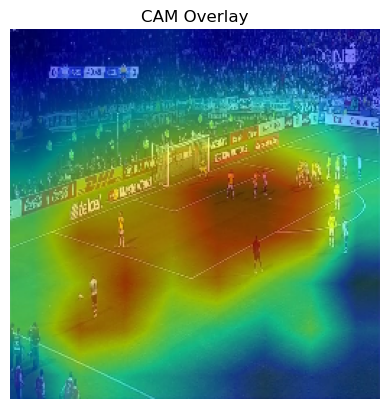

In [75]:
cam_resized, img_pre, cam_resized_original, img_orig = generate_cam(gate_model1,
                                                                    img_id=7599,
                                                                    req_dim=target_dim,
                                                                    return_original=True)
img_raw = load_images_from_path(image_ids=[7599], img_dim=target_dim)[0]
overlay_cam_on_image(image_array= img_raw.astype(np.uint8), cam=cam_resized)

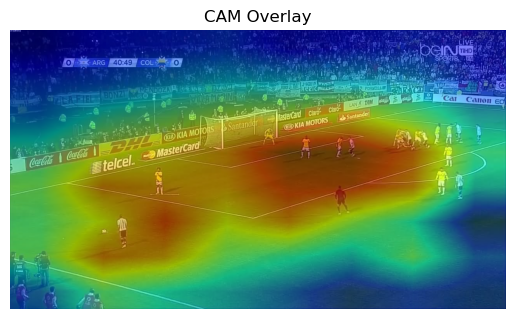

In [76]:
overlay_cam_on_image(image_array = img_orig, cam=cam_resized_original)

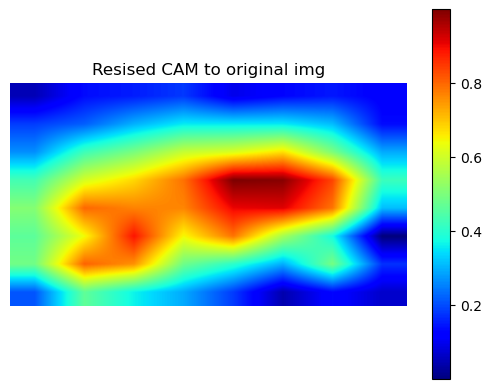

In [77]:
plt.imshow(cam_resized_original, cmap='jet')
plt.colorbar()
plt.title("Resised CAM to original img")
plt.axis("off")
plt.show()

##### 1.b Label=0

In [62]:
clues_df[clues_df['Gate']==0].sample(10).index

Index([81191, 29449, 69107, 52953, 72536, 20950, 40271, 15022, 21132, 78506], dtype='int64', name='img_id')

In [ ]:
tried_0 = [69082, 62026, 8902, 20950, 40271]

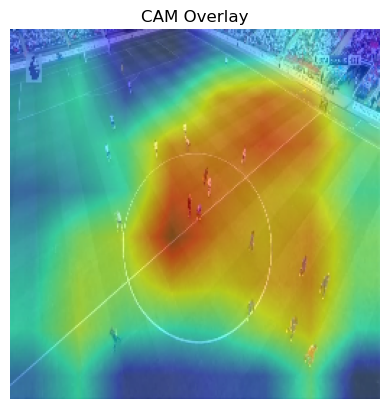

In [66]:
cam_resized, img_pre, cam_resized_original, img_orig = generate_cam(gate_model1,
                                                                    img_id=62026,
                                                                    req_dim=target_dim,
                                                                    return_original=True)
img_raw = load_images_from_path(image_ids=[62026], img_dim=target_dim)[0]
#overlay_cam_on_image(image_array = img_orig, cam=cam_resized_original)
overlay_cam_on_image(image_array= img_raw.astype(np.uint8), cam=cam_resized)

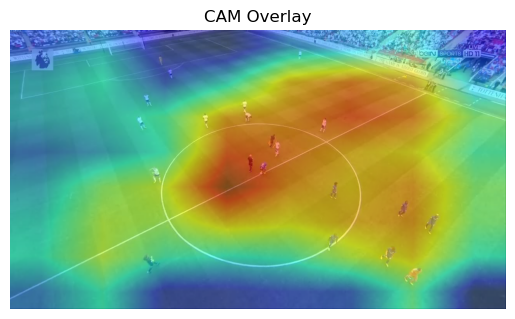

In [67]:
overlay_cam_on_image(image_array = img_orig, cam=cam_resized_original)

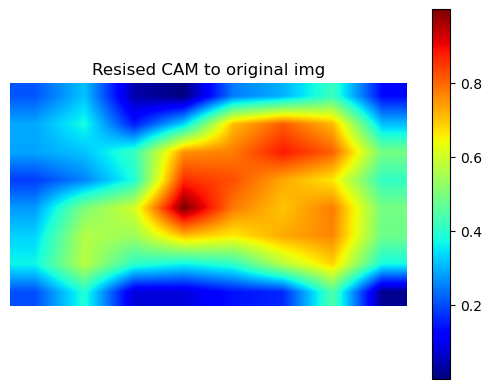

In [68]:
plt.imshow(cam_resized_original, cmap='jet')
plt.colorbar()
plt.title("Resised CAM to original img")
plt.axis("off")
plt.show()

**Considerations**

**Modality**: Manual CAM evaluation

# Step 23. From CAM into bounding boxes and masks

#### Bounding Box

We want to threshold the CAM, so convert it into a binary mask:
- 1: region that the model strongly associates with the clue
- 0: irrelevant background

In [69]:
def threshold_cam(cam, threshold=0.7, return_uint8=True):
    """
    Threshold CAM to create a binary mask.
    """
    binary_mask = (cam >= threshold).astype(np.uint8)
    if return_uint8:
        return binary_mask * 255
    return binary_mask


def get_bounding_box_from_mask(mask, min_area=500):
    """
    Extract the largest bounding box from the binary mask.
    Ignores small contours under min_area.
    Returns (x1, y1, x2, y2) or None if nothing found.
    """
    ## Ensure mask is 0/255 (OpenCV expects that)
    #if mask.max() <= 1:
    #    mask = (mask * 255).astype(np.uint8)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    # Filter out small contours
    large_contours = [c for c in contours if cv2.contourArea(c) > min_area]
    if not large_contours:
        return None

    largest = max(large_contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)
    return (x, y, x + w, y + h)



def draw_bounding_box(image, bbox, color=(255, 0, 0), thickness=2):
    """
    Draws a bounding box on the image.
    """
    if bbox is not None:
        x1, y1, x2, y2 = bbox
        image = image.copy()
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)
    return image


def mask_from_bbox(bbox, shape):
    """
    Returns a binary mask (0 or 1) of the same shape as the image,
    with the bounding box area set to 1.
    shape: (H, W)
    """
    mask = np.zeros(shape, dtype=np.uint8)
    if bbox is None:
        return mask
    x1, y1, x2, y2 = bbox
    mask[y1:y2, x1:x2] = 1
    return mask


Visualize Binary Mask:

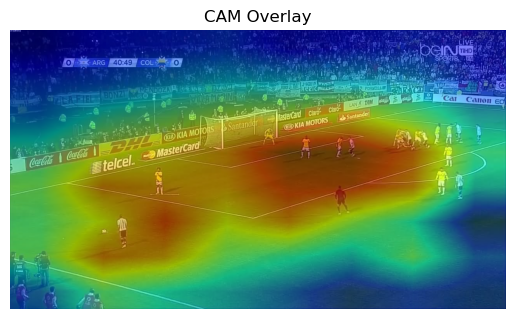

In [78]:
cam_resized, img_pre, cam_resized_original, img_orig = generate_cam(gate_model1,
                                                                    img_id=7599,
                                                                    req_dim=target_dim,
                                                                    return_original=True)
overlay_cam_on_image(image_array = img_orig, cam=cam_resized_original)

In [81]:
mask_bin = threshold_cam(cam_resized_original, threshold=0.8)

Bounding Box:

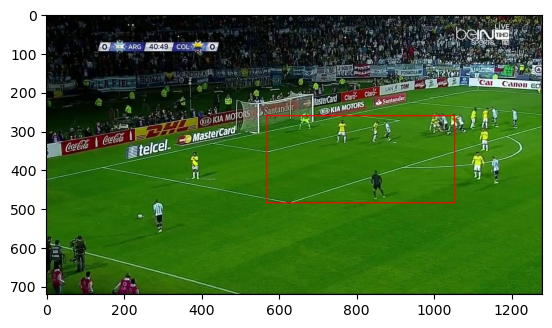

In [82]:
bbox = get_bounding_box_from_mask(mask_bin)
bounding_box = draw_bounding_box(image= img_orig, bbox=bbox)

plt.imshow(bounding_box.astype(np.uint8))

## Mask

In [180]:
print(f"cam shape: {cam_resized_original.shape}")
print(f"bbox: {bbox}")
print(f"bounding_box: {bounding_box.shape}")

cam shape: (720, 1280)
bbox: (796, 397, 1143, 598)
bounding_box: (720, 1280, 3)


In [83]:
#box_mask = mask_from_bbox(cam_resized_original.shape, bbox)
box_mask = mask_from_bbox(bbox, cam_resized_original.shape)

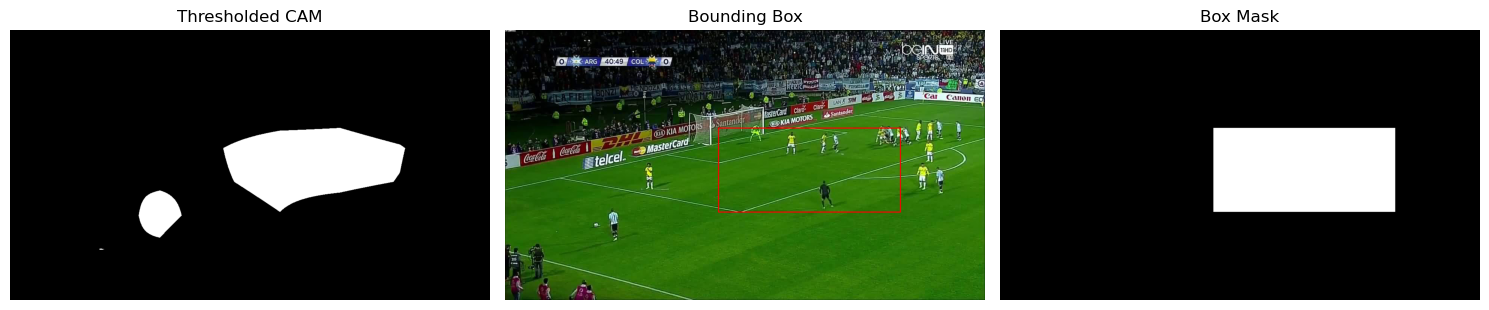

In [84]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(mask_bin, cmap='gray')
axs[0].set_title("Thresholded CAM")
axs[0].axis("off")

axs[1].imshow(bounding_box.astype(np.uint8))
axs[1].set_title("Bounding Box")
axs[1].axis("off")

axs[2].imshow(box_mask, cmap='gray')
axs[2].set_title("Box Mask")
axs[2].axis("off")

plt.tight_layout()
plt.show()

In [89]:
clues_df[clues_df['Gate'] == 1].sample(10).index

Index([67477, 85122, 54426, 76995, 76842, 53712, 52344, 36560, 41919, 39208], dtype='int64', name='img_id')

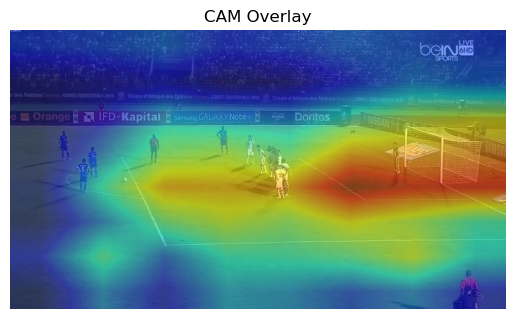

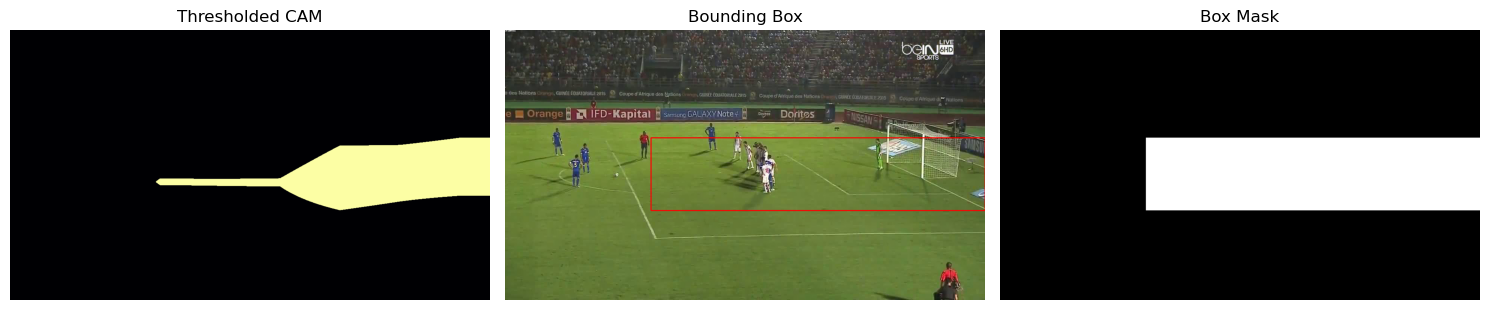

In [87]:
cam_resized, img_pre, cam_resized_original, img_orig = generate_cam(gate_model1,
                                                                    img_id=24632,
                                                                    req_dim=target_dim,
                                                                    return_original=True)
mask_bin = threshold_cam(cam_resized_original, threshold=0.7)
bbox = get_bounding_box_from_mask(mask_bin)
bounding_box = draw_bounding_box(image= img_orig, bbox=bbox)
box_mask = mask_from_bbox(bbox, cam_resized_original.shape)

overlay_cam_on_image(image_array = img_orig, cam=cam_resized_original)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(mask_bin, cmap='inferno')
axs[0].set_title("Thresholded CAM")
axs[0].axis("off")

axs[1].imshow(bounding_box.astype(np.uint8))
axs[1].set_title("Bounding Box")
axs[1].axis("off")

axs[2].imshow(box_mask, cmap='gray')
axs[2].set_title("Box Mask")
axs[2].axis("off")

plt.tight_layout()
plt.show()

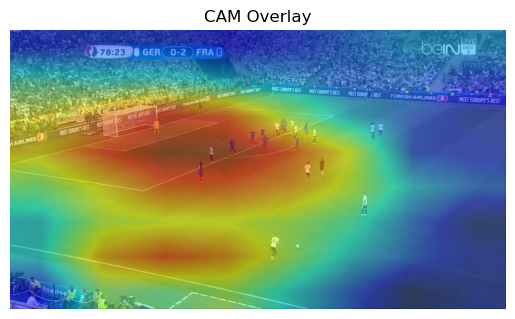

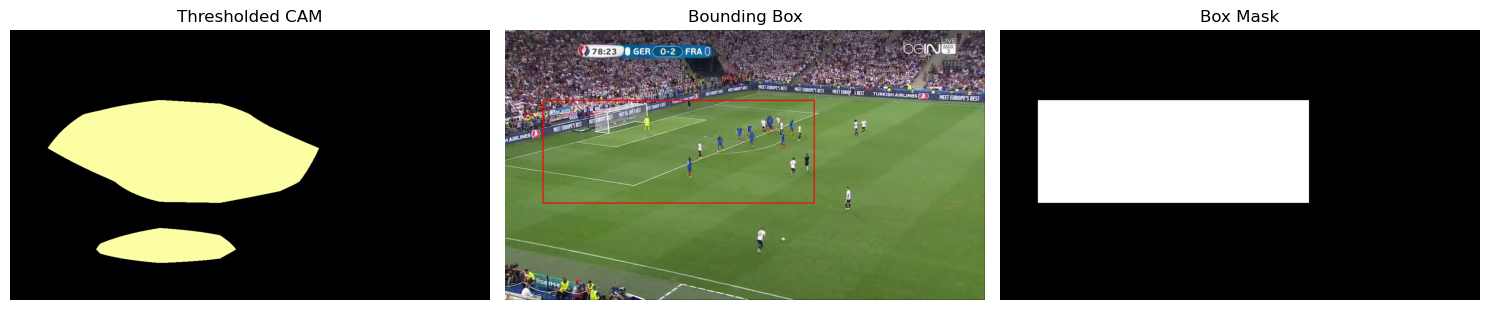

In [88]:
cam_resized, img_pre, cam_resized_original, img_orig = generate_cam(gate_model1,
                                                                    img_id=55548,
                                                                    req_dim=target_dim,
                                                                    return_original=True)
mask_bin = threshold_cam(cam_resized_original, threshold=0.7)
bbox = get_bounding_box_from_mask(mask_bin)
bounding_box = draw_bounding_box(image= img_orig, bbox=bbox)
box_mask = mask_from_bbox(bbox, cam_resized_original.shape)

overlay_cam_on_image(image_array = img_orig, cam=cam_resized_original)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(mask_bin, cmap='inferno')
axs[0].set_title("Thresholded CAM")
axs[0].axis("off")

axs[1].imshow(bounding_box.astype(np.uint8))
axs[1].set_title("Bounding Box")
axs[1].axis("off")

axs[2].imshow(box_mask, cmap='gray')
axs[2].set_title("Box Mask")
axs[2].axis("off")

plt.tight_layout()
plt.show()

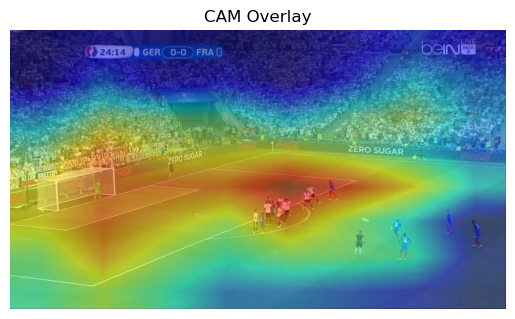

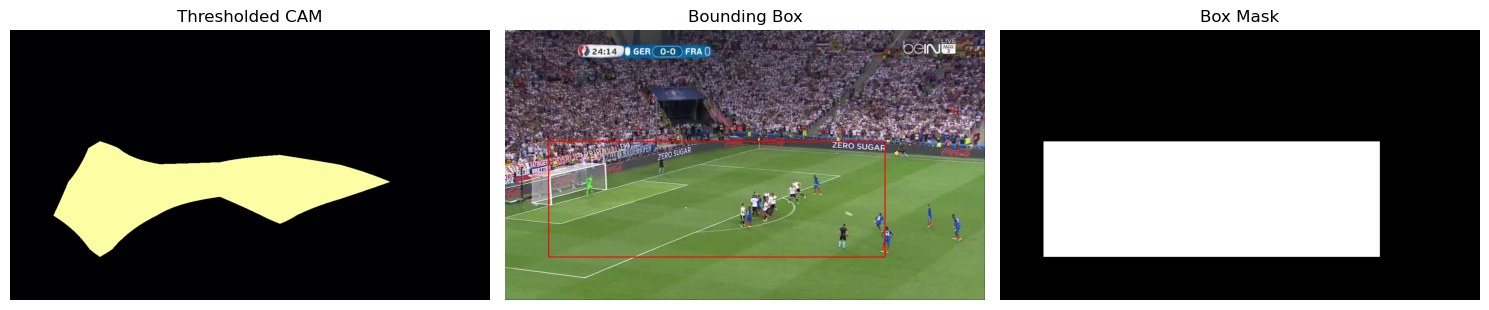

In [90]:
cam_resized, img_pre, cam_resized_original, img_orig = generate_cam(gate_model1,
                                                                    img_id=36560,
                                                                    req_dim=target_dim,
                                                                    return_original=True)
mask_bin = threshold_cam(cam_resized_original, threshold=0.7)
bbox = get_bounding_box_from_mask(mask_bin)
bounding_box = draw_bounding_box(image= img_orig, bbox=bbox)
box_mask = mask_from_bbox(bbox, cam_resized_original.shape)

overlay_cam_on_image(image_array = img_orig, cam=cam_resized_original)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(mask_bin, cmap='inferno')
axs[0].set_title("Thresholded CAM")
axs[0].axis("off")

axs[1].imshow(bounding_box.astype(np.uint8))
axs[1].set_title("Bounding Box")
axs[1].axis("off")

axs[2].imshow(box_mask, cmap='gray')
axs[2].set_title("Box Mask")
axs[2].axis("off")

plt.tight_layout()
plt.show()

# EXPORT MASKS

In [95]:
ids_selected = clues_df[clues_df['Gate']==1].index.tolist()
ids_selected[:10]

[350, 354, 355, 356, 366, 370, 372, 374, 375, 376]

In [96]:
print(f"Exporting masks for {len(ids_selected)} images.")

Exporting masks for 4150 images.


In [97]:
output_folder = 'Gate_Mask'
os.makedirs(output_folder, exist_ok=True)

In [100]:
def export_mask_for_image(img_id, model, output_dir, threshold=0.8, min_area=500):
    try:
        # Generate CAM
        __, __, cam_orig, img_orig = generate_cam(model, img_id, return_original=True)

        # Threshold CAM
        mask_bin = threshold_cam(cam_orig, threshold=threshold)

        # Extract bounding box
        bbox = get_bounding_box_from_mask(mask_bin, min_area=min_area)

        # Create binary mask from box
        box_mask = mask_from_bbox(bbox, cam_orig.shape)  # shape = (H, W)

        # Save as .png
        output_path = os.path.join(output_dir, f"{img_id}_mask.jpg")
        cv2.imwrite(output_path, box_mask * 255)  # ensure it's in [0, 255] for binary image

        return True
    except Exception as e:
        print(f"Failed to process img_id {img_id}: {e}")
        return False

In [99]:
from tqdm import tqdm

In [101]:
success_count = 0
for img_id in tqdm(ids_selected, desc="Exporting masks"):
    if export_mask_for_image(img_id, gate_model1, output_folder):
        success_count += 1

Exporting masks: 100%|██████████| 4150/4150 [17:35<00:00,  3.93it/s]
